### Task 1: Predicting Natural Gas Prices
#### Data Exploring

In [1]:
# import necessary library
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
import statsmodels.api as sm
import numpy as np

In [62]:
nat_gas = pd.read_csv('Nat_Gas.csv', index_col='Dates', parse_dates=True, date_format='%m/%d/%Y')
print(nat_gas.head())
print(nat_gas.isna().sum())

          Prices
Dates           
10/31/20    10.1
11/30/20    10.3
12/31/20    11.0
1/31/21     10.9
2/28/21     10.9
Prices    0
dtype: int64


#### Data Visualization

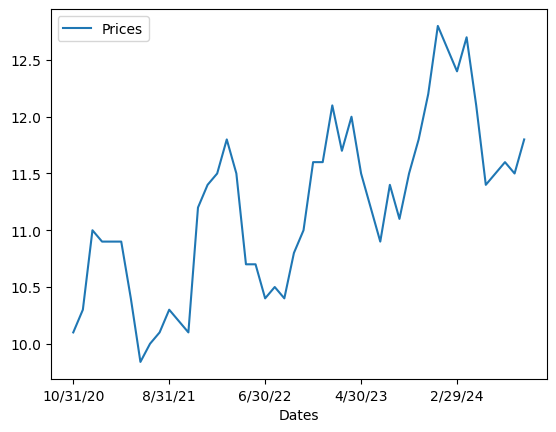

In [3]:
# check the seasonality in the natural gas prices
nat_gas.plot()
plt.show()

Here, I discovered that the data is seasonal, with potential non-seasonality. Thus, conducting ADF test for unit root.

In [4]:
# check the stationarity of the time series 
adf_result = adfuller(nat_gas['Prices'])
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.218077
p-value: 0.973257
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


From the result, the test statistic is higher than critical value at 10% level. Hence, we fail to reject the null that the series possess unit root, which means the series is non-stationary.

#### SARIMAX
##### Modeling

In [108]:
# searching for approriate parameters for the SARIMAX model
auto_arima(nat_gas['Prices'], seasonal=True, m=12, start_p=0, start_q=0, max_P=1, max_D=1, max_Q=1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                  -8.992
Date:                            Sun, 26 Nov 2023   AIC                             27.985
Time:                                    15:56:20   BIC                             37.235
Sample:                                10-31-2020   HQIC                            31.466
                                     - 09-30-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.002      0.152      0.879      -0.003       0.004
ma.L1         -0.9863      0.033    -30.273      0.000      -1.050      -0.922
ar.S.L12       0.9939      0.040     24.950      0.000       0.916       1.072
ma.S.L12      -0.7548      0.730     -1.034      0.301      -2.185       0.676
sigma2         0.0440      0.033      1.317      0.188      -0.021       0.109
===================================================================================
Ljung-Box (L1) (Q):                   1.77   Jarque-Bera (JB):                 1.23
Prob(Q):                              0.18   Prob(JB):                         0.54
Heteroskedasticity (H):               0.69   Skew:                            -0.09
Prob(H) (two-sided):                  0.46   Kurtosis:                         2.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### Testing accuracy
After generated the coefficients for SARIMAX model, I will seperate the data into two parts to test for its accuracy.

In [116]:
# train/test split
train = nat_gas.iloc[:len(nat_gas)-12,0]
test = nat_gas.iloc[len(nat_gas)-12:,0]

# fit the model
arima_model = sm.tsa.statespace.SARIMAX(train, order=(1,1,0), seasonal_order=(1,1,0,12))
arima_result = arima_model.fit()
arima_result.summary()


C:\Users\HaMar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\HaMar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\HaMar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\HaMar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             Prices   No. Observations:                   36
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  -3.710
Date:                            Sun, 26 Nov 2023   AIC                             13.419
Time:                                    15:57:30   BIC                             16.826
Sample:                                10-31-2020   HQIC                            14.276
                                     - 09-30-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8714      0.174     -5.008      0.000      -1.212      -0.530
ar.S.L12      -0.8872      0.132     -6.729      0.000      -1.146      -0.629
sigma2         0.0344      0.021      1.611      0.107      -0.007       0.076
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                 0.94
Prob(Q):                              0.55   Prob(JB):                         0.62
Heteroskedasticity (H):               0.98   Skew:                            -0.38
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In the SARIMAX model, I did not use the parameter that generated from auto_arima. The reason is that the parameters generated from auto_arima failed to capture the seasonality. Thus, I hand tuned the parameters for AR, MA, SAR and SMA, with objective to minimize the mean square error calculated below.

C:\Users\HaMar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


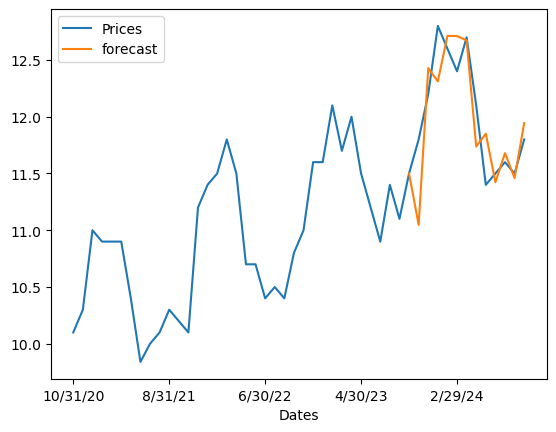

0.11137956222887575


In [117]:
# testing the fitted model
nat_gas['forecast'] = arima_result.predict(start=len(train), end=len(nat_gas)-1,typ='levels', dynamic=True)
nat_gas.iloc[len(train)-1, 1] = nat_gas.iloc[len(train)-1, 0]
nat_gas[['Prices','forecast']].plot()
plt.show()

# calculate the RMSE of the prediction
price_true = nat_gas.iloc[len(nat_gas)-12:, 0]
price_pred = nat_gas.iloc[len(nat_gas)-12:, 1]
arima_mse = np.square(np.subtract(price_true,price_pred)).mean()
print(arima_mse)

##### Predicting natural gas price for the next year

In [118]:
forecast_price = arima_result.predict(start=len(nat_gas), end=len(nat_gas)+12, typ='levels', dynamic=True)
print(forecast_price)
forecast_price.index = forecast_price.index.strftime('%m/%d/%Y')

2024-10-31    11.996595
2024-11-30    12.749197
2024-12-31    12.679843
2025-01-31    13.217687
2025-02-28    12.819883
2025-03-31    13.118967
2025-04-30    12.537414
2025-05-31    12.312341
2025-06-30    11.973213
2025-07-31    12.467276
2025-08-31    12.157582
2025-09-30    12.583471
2025-10-31    12.173531
Freq: M, Name: predicted_mean, dtype: float64


C:\Users\HaMar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\HaMar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


10/31/20      10.100000
11/30/20      10.300000
12/31/20      11.000000
1/31/21       10.900000
2/28/21       10.900000
                ...    
06/30/2025    11.973213
07/31/2025    12.467276
08/31/2025    12.157582
09/30/2025    12.583471
10/31/2025    12.173531
Length: 61, dtype: float64


<Axes: >

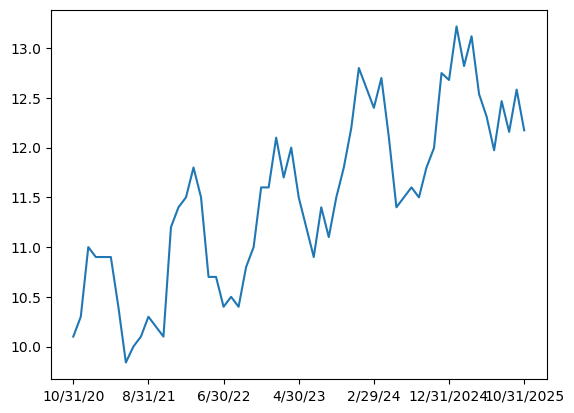

In [119]:
price = pd.concat([nat_gas['Prices'], forecast_price])
print(price)
price.plot()